In [0]:
pip install geopandas

  Obtaining dependency information for geopandas from https://files.pythonhosted.org/packages/0b/70/d5cd0696eff08e62fdbdebe5b46527facb4e7220eabe0ac6225efab50168/geopandas-1.1.1-py3-none-any.whl.metadata
  Obtaining dependency information for pyogrio>=0.7.2 from https://files.pythonhosted.org/packages/e7/99/81d9a441ac7709407750f359813889b9a3f6076999cb9ae8893d5ba7c707/pyogrio-0.11.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata
  Obtaining dependency information for pyproj>=3.5.0 from https://files.pythonhosted.org/packages/ad/ab/9bdb4a6216b712a1f9aab1c0fcbee5d3726f34a366f29c3e8c08a78d6b70/pyproj-3.7.2-cp311-cp311-manylinux_2_28_x86_64.whl.metadata
  Obtaining dependency information for shapely>=2.0.0 from https://files.pythonhosted.org/packages/13/02/58b0b8d9c17c93ab6340edd8b7308c0c5a5b81f94ce65705819b7416dba5/shapely-2.1.2-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/338.4 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━

In [0]:
pip install pyjstat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/798.0 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 788.5/798.0 kB 31.5 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.0/798.0 kB 22.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pyjstat: filename=pyjstat-2.4.0-py3-none-any.whl size=22762 sha256=75224902bcc5168c34867c11f41630d0199ab7d19307f5b6324a24a0eda461ab
  Stored in directory: /home/spark-f0c3083b-ed5c-4397-bb03-f8/.cache/pip/wheels/d7/b0/ac/350c026feabb6a22b2a5b3fb1f694e724c0f57c2c43ccaf738
Successfully built pyjstat
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


<Figure size 900x700 with 0 Axes>

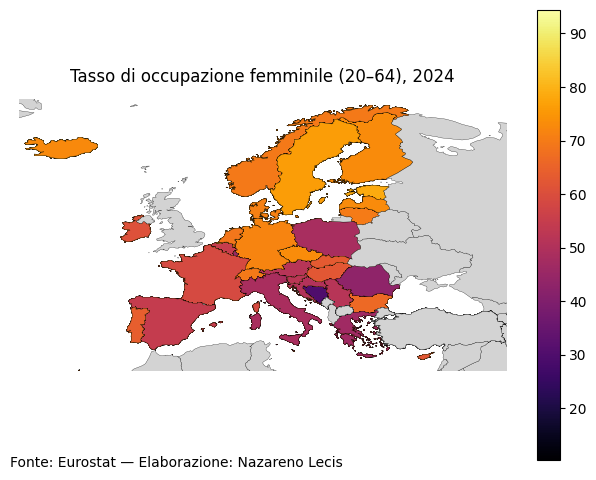

In [0]:
# Mappa Europa – Tasso occupazione femminile 20–64, ultimo anno
# Requisiti: pip install requests pandas pyjstat geopandas matplotlib

import re
import requests
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pyjstat import pyjstat

API_URL  = "https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/lfsi_emp_a"
GISCO_URL = "https://gisco-services.ec.europa.eu/distribution/v2/countries/geojson/CNTR_RG_20M_2024_4326.geojson"

# --------- 1) Eurostat: Females 20–64, unità percentuale, ultimo anno ----------
params = {
    "format": "JSON",
    "startPeriod": "2015",
    "sex": "F",
    "age": "Y20-64"
}
r = requests.get(API_URL, params=params, timeout=90)
r.raise_for_status()
tables = pyjstat.from_json_stat(r.json())
if not tables:
    raise RuntimeError("Nessuna tabella dall'API Eurostat.")
df = tables[0].rename(columns=str)

col_indicator = "Employment indicator"
col_unit      = "Unit of measure"
col_geo       = "Geopolitical entity (reporting)"
col_time      = "Time"
col_value     = "value"

def ci(s, pat):
    return bool(re.search(pat, s or "", re.IGNORECASE))

# Indicatore (concetto LFS) + unità in percentuale
mask_indicator = df[col_indicator].apply(
    lambda s: ci(s, r"Total employment\s*\(resident population concept\s*-\s*LFS\)") or ci(s, r"\bEmployment rate\b")
)
mask_unit = df[col_unit].apply(lambda s: ci(s, r"percent|%"))
df = df[mask_indicator & mask_unit].copy()
if df.empty:
    raise RuntimeError("Filtro vuoto: indicatore/percentuale non trovati.")

# Ultimo anno disponibile
def to_year(x):
    s = str(x)
    return int(s[:4]) if s[:4].isdigit() else None

df["year"] = df[col_time].map(to_year)
last_year = int(df["year"].dropna().max())

# Tieni solo ultimo anno
dfy = df[df["year"] == last_year][[col_geo, col_value]].copy()
dfy = dfy.rename(columns={col_geo: "geo_name", col_value: "female_emp_rate_20_64"})
dfy["female_emp_rate_20_64"] = pd.to_numeric(dfy["female_emp_rate_20_64"], errors="coerce")

# Rimuovi aggregati (UE/Area euro)
AGG_PATTERNS = [r"European Union", r"Euro area", r"countries\s*\(from"]
dfy = dfy[~dfy["geo_name"].apply(lambda s: any(re.search(p, s) for p in AGG_PATTERNS))].copy()

# --------- 2) GISCO: carica e join per nome (lascia la Turchia ma non colorarla) ----------
gdf = gpd.read_file(GISCO_URL)
if "NAME_ENGL" not in gdf.columns:
    raise RuntimeError(f"Colonna 'NAME_ENGL' non trovata in GISCO. Colonne: {list(gdf.columns)}")

merged = gdf[["NAME_ENGL", "geometry"]].merge(
    dfy, left_on="NAME_ENGL", right_on="geo_name", how="left"
)

# Non colorare la Turchia (lascia NaN)
merged.loc[merged["NAME_ENGL"].isin(["Turkey", "Türkiye"]), "female_emp_rate_20_64"] = None

# --------- 3) Plot: zoom Europa + cmap 'inferno' (scura→giallo) ----------
plt.figure(figsize=(9, 7))
ax = merged.plot(
    column="female_emp_rate_20_64",
    cmap="inferno",          # sequenziale scura→chiara fino al giallo
    legend=True,
    edgecolor="black",
    linewidth=0.2,
    missing_kwds={"color": "lightgrey", "label": "Nessun dato"}
)

# Limiti Europa
ax.set_xlim(-25, 45)
ax.set_ylim(33, 72)
ax.set_axis_off()

# Titolo pulito
plt.title(f"Tasso di occupazione femminile (20–64), {last_year}", pad=12)

# Fonte e credit in basso
plt.figtext(
    0.01, 0.01,
    "Fonte: Eurostat — Elaborazione: Nazareno Lecis",
    ha="left", va="bottom"
)

plt.tight_layout()
plt.show()

# # Opzionale: salvataggio
# plt.savefig(f"female_emp_rate_{last_year}_EUROPE_TR_grey_inferno.png", dpi=300, bbox_inches="tight")
